# Autocodificadores

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/autoencoder_schema.jpg)

An autoencoder is not used for supervised learning. We will no longer try to predict something about our input. Instead, an autoencoder is considered a generative model: it learns a distributed representation of our training data, and can even be used to generate new instances of the training data.

An autoencoder model contains two components:

- An encoder that takes an image as input, and outputs a low-dimensional embedding (representation) of the image.
- A decoder that takes the low-dimensional embedding, and reconstructs the image.

In [1]:
# http://pytorch.org/
from os.path import exists

import torch

In [31]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms

mnist_data = datasets.MNIST('data', train=True, download=True, transform=transforms.ToTensor())
mnist_data = list(mnist_data)[:4096]

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw



Here is an example of a convolutional autoencoder: an autoencoder that uses solely convolutional layers:

In [32]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential( # like the Composition layer you built
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

Notice that the final activation on the decoder is a sigmoid activation. The reason is that all of our image pixels are in the range [0, 1]. A sigmoid gives us results in the same range.

## Training an Autoencoder

How do we train an autoencoder? How do we know what kind of "encoder" and "decoder" we want?

One observation is that if we pass an image through the encoder, then pass the result through the decoder, we should get roughly the same image back. Ideally, reducing the dimensionality and then generating the image should give us the same result.

This observation provides us a training strategy: we will minimize the reconstruction error of the autoencoder across our training data. We use a loss function called MSELoss, which computes the square error at every pixel.

Beyond using a different loss function, the training scheme is roughly the same. Note that in the code below, we are using a new optimizer called Adam.

We switched to this optimizer not because it is specifically used for autoencoders, but because this is the optimizer that people tend to use in practice for convolutional neural networks. Feel free to use Adam for your other convolutional networks.

We are also saving the reconstructed images of the last iteration in every epoch. We want to look at these reconstructions at the end of training.

In [33]:
def train(model, num_epochs=5, batch_size=64, learning_rate=1e-3):
    torch.manual_seed(42)
    criterion = nn.MSELoss() # mean square error loss
    optimizer = torch.optim.Adam(model.parameters(),
                                 lr=learning_rate, 
                                 weight_decay=1e-5) # <--
    train_loader = torch.utils.data.DataLoader(mnist_data, 
                                               batch_size=batch_size, 
                                               shuffle=True)
    outputs = []
    for epoch in range(num_epochs):
        for data in train_loader:
            img, _ = data
            recon = model(img)
            loss = criterion(recon, img)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        print('Epoch:{}, Loss:{:.4f}'.format(epoch+1, float(loss)))
        outputs.append((epoch, img, recon),)
    return outputs

In [34]:
model = Autoencoder()
max_epochs = 20
outputs = train(model, num_epochs=max_epochs)

Epoch:1, Loss:0.0681
Epoch:2, Loss:0.0679
Epoch:3, Loss:0.0583
Epoch:4, Loss:0.0410
Epoch:5, Loss:0.0267
Epoch:6, Loss:0.0188
Epoch:7, Loss:0.0158
Epoch:8, Loss:0.0148
Epoch:9, Loss:0.0139
Epoch:10, Loss:0.0107
Epoch:11, Loss:0.0085
Epoch:12, Loss:0.0089
Epoch:13, Loss:0.0098
Epoch:14, Loss:0.0079
Epoch:15, Loss:0.0070
Epoch:16, Loss:0.0074
Epoch:17, Loss:0.0065
Epoch:18, Loss:0.0062
Epoch:19, Loss:0.0060
Epoch:20, Loss:0.0060


The loss goes down as we train, meaning that our reconstructed images look more and more like the actual images!

Let's look at the training progression: that is, the reconstructed images at various points of training:

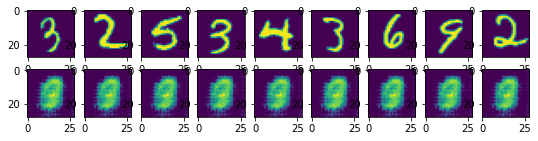

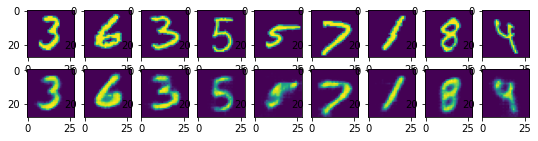

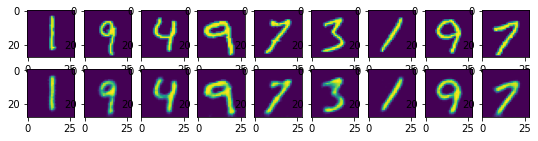

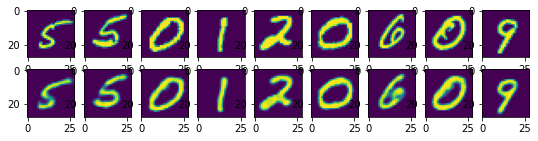

In [35]:
for k in range(0, max_epochs, 5):
    plt.figure(figsize=(9, 2))
    imgs = outputs[k][1].detach().numpy()
    recon = outputs[k][2].detach().numpy()
    for i, item in enumerate(imgs):
        if i >= 9: break
        plt.subplot(2, 9, i+1)
        plt.imshow(item[0])
        
    for i, item in enumerate(recon):
        if i >= 9: break
        plt.subplot(2, 9, 9+i+1)
        plt.imshow(item[0])

At first, the reconstructed images look nothing like the originals. Rather, the reconstructions look more like the average of some training images. As training progresses, our reconstructions are clearer.

## Structure in the Embeddings
Since we are drastically reducing the dimensionality of the image, there has to be some kind of structure in the embedding space. That is, the network should be able to "save" space by mapping similar images to similar embeddings.

We will demonstrate the structure of the embedding space by hving some fun with our autoencoders. Let's begin with two images in our training set. For now, we'll choose images of the same digit.

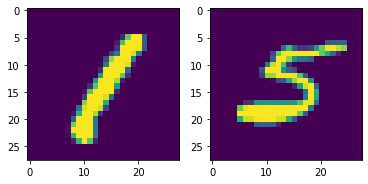

In [36]:
imgs = outputs[max_epochs-1][1].detach().numpy()
plt.subplot(1, 2, 1)
plt.imshow(imgs[0][0])
plt.subplot(1, 2, 2)
plt.imshow(imgs[8][0])

We will then compute the low-dimensional embeddings of both images, by applying the encoder:

In [37]:
x1 = outputs[max_epochs-1][1][0,:,:,:] # first image
x2 = outputs[max_epochs-1][1][8,:,:,:] # second image
x = torch.stack([x1,x2])     # stack them together so we only call `encoder` once
embedding = model.encoder(x)
e1 = embedding[0] # embedding of first image
e2 = embedding[1] # embedding of second image

Now we will do something interesting. Not only are we goign to run the decoder on those two embeddings e1 and e2, we are also going to interpolate between the two embeddings and decode those as well!

In [38]:
embedding_values = []
for i in range(0, 10):
    e = e1 * (i/10) + e2 * (10-i)/10
    embedding_values.append(e)
embedding_values = torch.stack(embedding_values)

recons = model.decoder(embedding_values)

Let's plot the reconstructions of each interpolated values. The original images are shown below too:

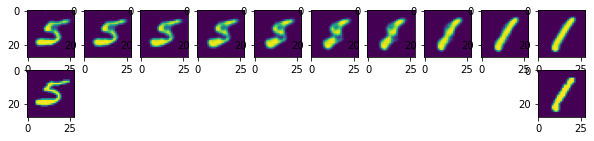

In [39]:
plt.figure(figsize=(10, 2))
for i, recon in enumerate(recons.detach().numpy()):
    plt.subplot(2,10,i+1)
    plt.imshow(recon[0])
plt.subplot(2,10,11)
plt.imshow(imgs[8][0])
plt.subplot(2,10,20)
plt.imshow(imgs[0][0])

Notice that there is a smooth transition between the two images! The middle images are likely new, in that there are no training images that are exactly like any of the generated images.

As promised, we can do the same thing with two images containing different digits. There should be a smooth transition between the two digits.

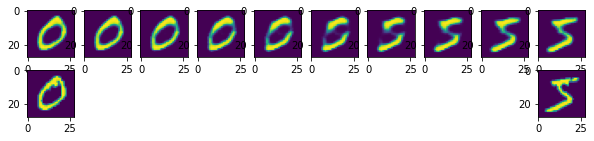

In [40]:
def interpolate(index1, index2):
    x1 = mnist_data[index1][0]
    x2 = mnist_data[index2][0]
    x = torch.stack([x1,x2])
    embedding = model.encoder(x)
    e1 = embedding[0] # embedding of first image
    e2 = embedding[1] # embedding of second image


    embedding_values = []
    for i in range(0, 10):
        e = e1 * (i/10) + e2 * (10-i)/10
        embedding_values.append(e)
    embedding_values = torch.stack(embedding_values)

    recons = model.decoder(embedding_values)

    plt.figure(figsize=(10, 2))
    for i, recon in enumerate(recons.detach().numpy()):
        plt.subplot(2,10,i+1)
        plt.imshow(recon[0])
    plt.subplot(2,10,11)
    plt.imshow(x2[0])
    plt.subplot(2,10,20)
    plt.imshow(x1[0])

interpolate(0, 1)

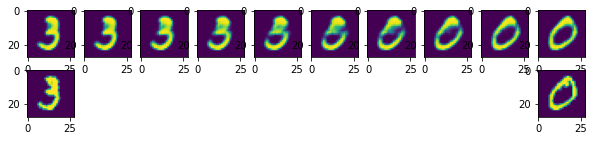

In [41]:
interpolate(1, 10)

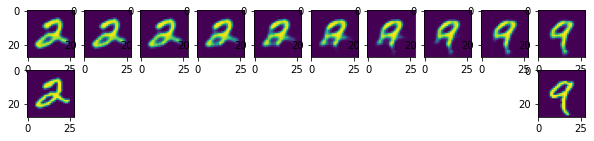

In [42]:
interpolate(4, 5)

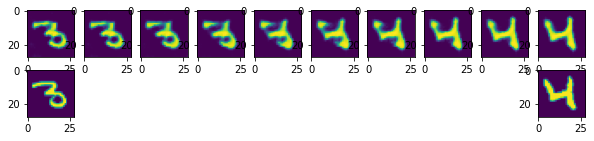

In [43]:
interpolate(20, 30)

# Exercício

Refaça o algoritmo de autoencoder para o problema MNIST, só que dessa vez, siga a arquitetura de rede exibida abaixo

![alt text](https://raw.githubusercontent.com/vcasadei/images/master/autoencoder_1.png)
</table>